In [4]:
import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs
import matplotlib.pyplot as plt

In [5]:
from crowd_nav.imitate import *

### Testing models

In [6]:
def test(model_type='sail', visible=False, n_episodes=100, model_path=None, itera=range(4, 199, 5)) :
    res_list = []
    if model_path is None :
        if model_type != 'sail' :
            model_path = 'data/output/imitate-baseline-data-0.5-traj/'
        else :
            model_path = 'data/output/imitate-baseline-data-0.5-notraj/'
    for i in itera :
        s = str(i) if i > 10 else '0{}'.format(i)
        res = test_model(model_path + 'policy_net_{}.pth'.format(s), model_type=model_type, visible=visible, n_episodes=n_episodes)
        res_list.append((i, res))
    return res_list

In [7]:
def test_model(m_p, model_type, visible=False, n_episodes=5000) :
    policy_p = 'configs/policy.config'
    if not visible : 
        env_p = 'configs/env.config'
    else :
        env_p = 'configs/env_visible.config'
    policy_type = model_type
    
    # configure policy
    policy = policy_factory[policy_type]()
    policy_config = configparser.RawConfigParser()
    policy_config.read(policy_p)
    policy.configure(policy_config)

    # configure environment
    env_config = configparser.RawConfigParser()
    env_config.read(env_p)
    env = CrowdSim()
    env.configure(env_config)

    robot = Robot(env_config, 'robot')
    robot.set_policy(policy)
    env.set_robot(robot)
    policy.set_env(env)

    policy.set_env(env)
    policy.set_phase('val')
    policy.set_device('cpu')

    policy.model.load_state_dict(torch.load(m_p))
    
    if model_type == 'sail' :
        explorer = ExplorerDs(env, robot, 'cpu', 1, gamma=0.9)
    else :
        explorer = ExplorerDs(env, robot, 'cpu', 5, gamma=0.9)
    explorer.robot = robot
    
    return explorer.run_k_episodes(n_episodes, 'val', progressbar=True, output_info=True, notebook=True, print_info=True)

#### Baseline vs Traj

**baseline**

In [70]:
top_n_models = 5
model_path = 'data/output/basetests/imitate-baseline-data-0.5-notraj/'
basline_results = test('sail', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
best_baseline_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]

success: 0.75, collision: 0.25, nav time: 10.42, reward: 0.2032 +- 0.2219


success: 0.84, collision: 0.16, nav time: 10.32, reward: 0.2490 +- 0.1862


success: 0.79, collision: 0.21, nav time: 10.57, reward: 0.2227 +- 0.2025


success: 0.90, collision: 0.10, nav time: 10.47, reward: 0.2884 +- 0.1472


success: 0.87, collision: 0.13, nav time: 10.70, reward: 0.2610 +- 0.1723


success: 0.87, collision: 0.13, nav time: 10.53, reward: 0.2667 +- 0.1736


success: 0.79, collision: 0.21, nav time: 10.40, reward: 0.2187 +- 0.2172


success: 0.86, collision: 0.14, nav time: 10.37, reward: 0.2653 +- 0.1806


success: 0.83, collision: 0.17, nav time: 10.20, reward: 0.2536 +- 0.1859


success: 0.94, collision: 0.06, nav time: 10.44, reward: 0.3050 +- 0.1206


success: 0.92, collision: 0.08, nav time: 10.32, reward: 0.2957 +- 0.1384


success: 0.86, collision: 0.14, nav time: 10.36, reward: 0.2604 +- 0.1797


success: 0.89, collision: 0.11, nav time: 10.47, reward: 0.2723 +- 0.1615


success: 0.91, collision: 0.09, nav time: 10.46, reward: 0.2846 +- 0.1487


success: 0.76, collision: 0.24, nav time: 10.29, reward: 0.2060 +- 0.2231


success: 0.91, collision: 0.09, nav time: 10.14, reward: 0.2956 +- 0.1479


success: 0.85, collision: 0.15, nav time: 10.34, reward: 0.2527 +- 0.1881


success: 0.94, collision: 0.06, nav time: 10.39, reward: 0.3033 +- 0.1317


success: 0.91, collision: 0.09, nav time: 10.55, reward: 0.2801 +- 0.1595


success: 0.87, collision: 0.13, nav time: 10.34, reward: 0.2673 +- 0.1730


In [73]:
n_ep = 500
results_baseline = []
for n_epochs, _ in best_baseline_results : 
    model_path = 'data/output/basetests/imitate-baseline-data-0.5-notraj/policy_net_{:02d}.pth'.format(n_epochs)
    results_baseline.append(test_model(model_path, 'sail', n_episodes=500, visible=False))

success: 0.94, collision: 0.06, nav time: 10.39, reward: 0.3033 +- 0.1312


success: 0.87, collision: 0.13, nav time: 10.34, reward: 0.2673 +- 0.1723


success: 0.91, collision: 0.09, nav time: 10.14, reward: 0.2956 +- 0.1473


success: 0.79, collision: 0.21, nav time: 10.40, reward: 0.2187 +- 0.2163


success: 0.83, collision: 0.17, nav time: 10.20, reward: 0.2536 +- 0.1851


In [71]:
top_n_models = 5
model_path = 'data/output/basetests/imitate-baseline-data-0.5-traj/'
traj_results = test('sail_traj_simple', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
best_traj_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]

success: 0.69, collision: 0.31, nav time: 10.25, reward: 0.1783 +- 0.2377


success: 0.65, collision: 0.35, nav time: 9.95, reward: 0.1545 +- 0.2470


success: 0.76, collision: 0.24, nav time: 10.04, reward: 0.2140 +- 0.2242


success: 0.89, collision: 0.11, nav time: 10.42, reward: 0.2791 +- 0.1572


success: 0.73, collision: 0.27, nav time: 10.02, reward: 0.1963 +- 0.2313


success: 0.76, collision: 0.24, nav time: 10.18, reward: 0.2055 +- 0.2194


success: 0.80, collision: 0.20, nav time: 10.36, reward: 0.2271 +- 0.2087


success: 0.83, collision: 0.17, nav time: 10.33, reward: 0.2483 +- 0.1835


success: 0.82, collision: 0.18, nav time: 10.41, reward: 0.2388 +- 0.2036


success: 0.83, collision: 0.17, nav time: 10.23, reward: 0.2531 +- 0.1958


success: 0.82, collision: 0.18, nav time: 10.09, reward: 0.2438 +- 0.2103


success: 0.84, collision: 0.16, nav time: 10.59, reward: 0.2493 +- 0.1802


success: 0.86, collision: 0.14, nav time: 10.26, reward: 0.2613 +- 0.1862


success: 0.86, collision: 0.14, nav time: 10.40, reward: 0.2582 +- 0.1863


success: 0.82, collision: 0.18, nav time: 10.48, reward: 0.2375 +- 0.2007


success: 0.90, collision: 0.10, nav time: 10.43, reward: 0.2836 +- 0.1549


success: 0.81, collision: 0.19, nav time: 10.36, reward: 0.2379 +- 0.2055


success: 0.82, collision: 0.18, nav time: 10.16, reward: 0.2467 +- 0.2052


success: 0.93, collision: 0.07, nav time: 10.56, reward: 0.2940 +- 0.1392


success: 0.84, collision: 0.16, nav time: 10.25, reward: 0.2551 +- 0.1983


In [75]:
n_ep = 500
results_traj = []
for n_epochs, _ in best_traj_results : 
    model_path = 'data/output/basetests/imitate-baseline-data-0.5-traj/policy_net_{:02d}.pth'.format(n_epochs)
    results_traj.append(test_model(model_path, 'sail_traj_simple', n_episodes=500, visible=False))

success: 0.82, collision: 0.18, nav time: 10.16, reward: 0.2467 +- 0.2044


success: 0.84, collision: 0.16, nav time: 10.25, reward: 0.2551 +- 0.1975


success: 0.90, collision: 0.10, nav time: 10.43, reward: 0.2836 +- 0.1543


success: 0.80, collision: 0.20, nav time: 10.36, reward: 0.2271 +- 0.2079


success: 0.82, collision: 0.18, nav time: 10.41, reward: 0.2388 +- 0.2028


In [79]:
avg_baseline = np.mean([res['reward'] for res in results_baseline])
avg_traj = np.mean([res['reward'] for res in results_traj])
print(avg_baseline, avg_traj)

0.267704157273084 0.2502563517568365


#### Baseline

In [10]:
top_n_models = 5

In [11]:
best_m_per_length_base = []
model_path = 'data/output/imitate-baseline-data-0.5-notraj/'
model_results = test('sail', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
best_rew_model_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]
best_m_per_length_base.append(best_rew_model_results)

success: 0.47, collision: 0.53, nav time: 9.98, reward: 0.0776 +- 0.2514


success: 0.57, collision: 0.43, nav time: 10.73, reward: 0.1219 +- 0.2365


success: 0.63, collision: 0.37, nav time: 10.37, reward: 0.1465 +- 0.2474


success: 0.27, collision: 0.73, nav time: 10.25, reward: -0.0425 +- 0.2315


success: 0.82, collision: 0.18, nav time: 10.62, reward: 0.2471 +- 0.1843


success: 0.72, collision: 0.28, nav time: 10.22, reward: 0.1972 +- 0.2324


success: 0.74, collision: 0.26, nav time: 10.43, reward: 0.2015 +- 0.2266


success: 0.73, collision: 0.27, nav time: 10.31, reward: 0.1992 +- 0.2285


success: 0.62, collision: 0.38, nav time: 10.23, reward: 0.1418 +- 0.2492


success: 0.73, collision: 0.27, nav time: 10.22, reward: 0.1997 +- 0.2269


success: 0.70, collision: 0.30, nav time: 10.55, reward: 0.1786 +- 0.2360


success: 0.69, collision: 0.31, nav time: 10.46, reward: 0.1782 +- 0.2318


success: 0.58, collision: 0.42, nav time: 10.17, reward: 0.1215 +- 0.2588


success: 0.60, collision: 0.40, nav time: 10.38, reward: 0.1271 +- 0.2583


success: 0.81, collision: 0.19, nav time: 10.67, reward: 0.2287 +- 0.2055


success: 0.69, collision: 0.31, nav time: 10.65, reward: 0.1728 +- 0.2328


success: 0.70, collision: 0.30, nav time: 10.23, reward: 0.1823 +- 0.2390


success: 0.75, collision: 0.25, nav time: 10.49, reward: 0.2001 +- 0.2248


success: 0.60, collision: 0.40, nav time: 10.07, reward: 0.1318 +- 0.2530


success: 0.75, collision: 0.25, nav time: 10.42, reward: 0.2085 +- 0.2172


In [12]:
n_ep = 500
results_base = []
for n_epochs, _ in best_m_per_length_base[0] : 
    model_path = 'data/output/imitate-baseline-data-0.5-notraj/policy_net_{:02d}.pth'.format(n_epochs)
    results_base.append(test_model(model_path, 'sail', n_episodes=500, visible=False))
        

success: 0.82, collision: 0.18, nav time: 10.62, reward: 0.2471 +- 0.1835


success: 0.81, collision: 0.19, nav time: 10.67, reward: 0.2287 +- 0.2046


success: 0.75, collision: 0.25, nav time: 10.42, reward: 0.2085 +- 0.2163


success: 0.74, collision: 0.26, nav time: 10.43, reward: 0.2015 +- 0.2257


success: 0.75, collision: 0.25, nav time: 10.49, reward: 0.2001 +- 0.2239


In [15]:
torch.save(best_m_per_length_base, 'data/testing/unipredtests_vis/best_m_per_length_base.pth')
torch.save(results_base, 'data/testing/unipredtests_vis/results_base.pth')

#### Baseline+contrastive

In [16]:
best_m_per_length_cont = []
model_path = 'data/output/imitate-event-data-0.5-weight-0.5-horizon-4-temperature-0.20-nboundary-0-notraj/'
model_results = test('sail', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
best_rew_model_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]
best_m_per_length_cont.append(best_rew_model_results)

success: 0.28, collision: 0.72, nav time: 9.41, reward: -0.0300 +- 0.2412


success: 0.63, collision: 0.37, nav time: 9.98, reward: 0.1628 +- 0.2447


success: 0.74, collision: 0.26, nav time: 10.35, reward: 0.2041 +- 0.2160


success: 0.69, collision: 0.31, nav time: 10.05, reward: 0.1791 +- 0.2377


success: 0.92, collision: 0.08, nav time: 10.49, reward: 0.2927 +- 0.1363


success: 0.85, collision: 0.15, nav time: 10.24, reward: 0.2568 +- 0.1803


success: 0.83, collision: 0.17, nav time: 10.34, reward: 0.2499 +- 0.1933


success: 0.85, collision: 0.15, nav time: 10.35, reward: 0.2591 +- 0.1809


success: 0.89, collision: 0.11, nav time: 10.50, reward: 0.2747 +- 0.1617


success: 0.81, collision: 0.19, nav time: 10.25, reward: 0.2379 +- 0.2082


success: 0.84, collision: 0.16, nav time: 10.31, reward: 0.2517 +- 0.1963


success: 0.86, collision: 0.14, nav time: 10.49, reward: 0.2572 +- 0.1719


success: 0.85, collision: 0.14, nav time: 10.61, reward: 0.2604 +- 0.1727


success: 0.90, collision: 0.09, nav time: 10.43, reward: 0.2783 +- 0.1547


success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.3012 +- 0.1320


success: 0.95, collision: 0.05, nav time: 10.69, reward: 0.2990 +- 0.1116


success: 0.93, collision: 0.07, nav time: 10.79, reward: 0.2921 +- 0.1220


success: 0.86, collision: 0.14, nav time: 10.30, reward: 0.2727 +- 0.1721


success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2853 +- 0.1505


success: 0.85, collision: 0.15, nav time: 10.41, reward: 0.2517 +- 0.1899


In [17]:
n_ep = 500
results_cont = []
for n_epochs, _ in best_m_per_length_cont[0] : 
    model_path = 'data/output/imitate-event-data-0.5-weight-0.5-horizon-4-temperature-0.20-nboundary-0-notraj/policy_net_{:02d}.pth'.format(n_epochs)
    results_cont.append(test_model(model_path, 'sail', n_episodes=500, visible=False))
        

success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.3012 +- 0.1315


success: 0.95, collision: 0.05, nav time: 10.69, reward: 0.2990 +- 0.1111


success: 0.92, collision: 0.08, nav time: 10.49, reward: 0.2927 +- 0.1358


success: 0.93, collision: 0.07, nav time: 10.79, reward: 0.2921 +- 0.1215


success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2853 +- 0.1499


In [18]:
torch.save(best_m_per_length_cont, 'data/testing/unipredtests_vis/best_m_per_length_cont.pth')
torch.save(results_cont, 'data/testing/unipredtests_vis/results_cont.pth')

#### Traj+n-TP

In [19]:
best_m_per_length_pred = []
top_n_models = 5
for n in range(6) :
    pred_length = n+1
    print(pred_length)
    print()
    model_path = 'data/output/trajtests/imitate-trajpred-0.3-weight-{}-length-traj/'.format(pred_length)
    model_results = test('sail_traj_simple', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
    best_coll_model_results = sorted(model_results.copy(), reverse=False, key=lambda x : x[1]['collision'])[:top_n_models]
    best_rew_model_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]
    best_m_per_length_pred.append((best_rew_model_results, best_coll_model_results))

1



success: 0.34, collision: 0.66, nav time: 9.83, reward: 0.0100 +- 0.2462


success: 0.45, collision: 0.55, nav time: 10.01, reward: 0.0663 +- 0.2567


success: 0.38, collision: 0.62, nav time: 9.97, reward: 0.0265 +- 0.2495


success: 0.39, collision: 0.61, nav time: 9.97, reward: 0.0277 +- 0.2490


success: 0.70, collision: 0.30, nav time: 10.24, reward: 0.1792 +- 0.2363


success: 0.82, collision: 0.18, nav time: 10.61, reward: 0.2400 +- 0.1929


success: 0.69, collision: 0.31, nav time: 10.02, reward: 0.1787 +- 0.2395


success: 0.82, collision: 0.18, nav time: 10.20, reward: 0.2483 +- 0.1966


success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2866 +- 0.1466


success: 0.89, collision: 0.11, nav time: 10.52, reward: 0.2724 +- 0.1585


success: 0.89, collision: 0.11, nav time: 10.54, reward: 0.2675 +- 0.1651


success: 0.79, collision: 0.21, nav time: 10.32, reward: 0.2217 +- 0.2079


success: 0.88, collision: 0.12, nav time: 10.61, reward: 0.2584 +- 0.1802


success: 0.89, collision: 0.09, nav time: 10.45, reward: 0.2764 +- 0.1560


success: 0.85, collision: 0.15, nav time: 10.43, reward: 0.2509 +- 0.1842


success: 0.91, collision: 0.09, nav time: 10.70, reward: 0.2789 +- 0.1527


success: 0.86, collision: 0.14, nav time: 10.31, reward: 0.2707 +- 0.1725


success: 0.84, collision: 0.16, nav time: 10.52, reward: 0.2375 +- 0.1978


success: 0.90, collision: 0.10, nav time: 10.44, reward: 0.2800 +- 0.1589


success: 0.92, collision: 0.08, nav time: 10.53, reward: 0.2930 +- 0.1478
2



success: 0.35, collision: 0.65, nav time: 10.07, reward: 0.0061 +- 0.2484


success: 0.45, collision: 0.55, nav time: 9.98, reward: 0.0605 +- 0.2600


success: 0.62, collision: 0.38, nav time: 10.33, reward: 0.1479 +- 0.2407


success: 0.73, collision: 0.27, nav time: 10.36, reward: 0.1916 +- 0.2307


success: 0.72, collision: 0.28, nav time: 10.25, reward: 0.1897 +- 0.2420


success: 0.85, collision: 0.15, nav time: 10.41, reward: 0.2591 +- 0.1875


success: 0.77, collision: 0.23, nav time: 10.55, reward: 0.2083 +- 0.2257


success: 0.72, collision: 0.28, nav time: 10.28, reward: 0.1879 +- 0.2398


success: 0.87, collision: 0.13, nav time: 10.41, reward: 0.2712 +- 0.1707


success: 0.90, collision: 0.10, nav time: 10.67, reward: 0.2727 +- 0.1620


success: 0.79, collision: 0.21, nav time: 10.10, reward: 0.2334 +- 0.2064


success: 0.75, collision: 0.25, nav time: 10.27, reward: 0.2032 +- 0.2220


success: 0.68, collision: 0.32, nav time: 10.14, reward: 0.1671 +- 0.2486


success: 0.87, collision: 0.13, nav time: 10.68, reward: 0.2599 +- 0.1819


success: 0.87, collision: 0.12, nav time: 10.44, reward: 0.2682 +- 0.1713


success: 0.86, collision: 0.14, nav time: 10.51, reward: 0.2578 +- 0.1775


success: 0.86, collision: 0.14, nav time: 10.52, reward: 0.2567 +- 0.1768


success: 0.91, collision: 0.08, nav time: 10.74, reward: 0.2835 +- 0.1432


success: 0.89, collision: 0.11, nav time: 10.59, reward: 0.2706 +- 0.1649


success: 0.78, collision: 0.22, nav time: 10.37, reward: 0.2148 +- 0.2197
3



success: 0.48, collision: 0.52, nav time: 10.72, reward: 0.0780 +- 0.2440


success: 0.53, collision: 0.47, nav time: 9.88, reward: 0.1102 +- 0.2631


success: 0.74, collision: 0.26, nav time: 10.60, reward: 0.2030 +- 0.2147


success: 0.84, collision: 0.16, nav time: 10.42, reward: 0.2550 +- 0.1833


success: 0.80, collision: 0.20, nav time: 10.30, reward: 0.2368 +- 0.2057


success: 0.84, collision: 0.16, nav time: 10.44, reward: 0.2487 +- 0.1879


success: 0.78, collision: 0.22, nav time: 10.44, reward: 0.2106 +- 0.2174


success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.2995 +- 0.1166


success: 0.95, collision: 0.05, nav time: 10.50, reward: 0.3029 +- 0.1209


success: 0.83, collision: 0.17, nav time: 10.59, reward: 0.2332 +- 0.1962


success: 0.75, collision: 0.25, nav time: 10.42, reward: 0.2015 +- 0.2305


success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2849 +- 0.1576


success: 0.89, collision: 0.11, nav time: 10.52, reward: 0.2742 +- 0.1582


success: 0.96, collision: 0.04, nav time: 10.56, reward: 0.3067 +- 0.1058


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2973 +- 0.1242


success: 0.94, collision: 0.06, nav time: 10.63, reward: 0.2966 +- 0.1268


success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2890 +- 0.1558


success: 0.92, collision: 0.08, nav time: 10.52, reward: 0.2905 +- 0.1436


success: 0.83, collision: 0.17, nav time: 10.33, reward: 0.2362 +- 0.2074


success: 0.84, collision: 0.16, nav time: 10.57, reward: 0.2461 +- 0.1862
4



success: 0.33, collision: 0.67, nav time: 10.05, reward: 0.0030 +- 0.2446


success: 0.55, collision: 0.44, nav time: 10.46, reward: 0.1075 +- 0.2522


success: 0.50, collision: 0.50, nav time: 10.07, reward: 0.0821 +- 0.2625


success: 0.56, collision: 0.44, nav time: 10.21, reward: 0.1072 +- 0.2652


success: 0.69, collision: 0.31, nav time: 10.29, reward: 0.1710 +- 0.2375


success: 0.81, collision: 0.19, nav time: 10.46, reward: 0.2371 +- 0.2036


success: 0.89, collision: 0.11, nav time: 10.61, reward: 0.2771 +- 0.1518


success: 0.78, collision: 0.22, nav time: 10.37, reward: 0.2172 +- 0.2190


success: 0.69, collision: 0.31, nav time: 10.06, reward: 0.1844 +- 0.2383


success: 0.87, collision: 0.13, nav time: 10.52, reward: 0.2710 +- 0.1667


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2972 +- 0.1296


success: 0.92, collision: 0.08, nav time: 10.46, reward: 0.2970 +- 0.1372


success: 0.84, collision: 0.16, nav time: 10.45, reward: 0.2474 +- 0.1890


success: 0.97, collision: 0.03, nav time: 10.66, reward: 0.3131 +- 0.0940


success: 0.89, collision: 0.11, nav time: 10.70, reward: 0.2681 +- 0.1607


success: 0.88, collision: 0.12, nav time: 10.46, reward: 0.2729 +- 0.1668


success: 0.87, collision: 0.13, nav time: 10.42, reward: 0.2737 +- 0.1660


success: 0.90, collision: 0.10, nav time: 10.36, reward: 0.2857 +- 0.1513


success: 0.93, collision: 0.07, nav time: 10.68, reward: 0.2938 +- 0.1248


success: 0.74, collision: 0.26, nav time: 10.20, reward: 0.1950 +- 0.2341
5



success: 0.38, collision: 0.62, nav time: 10.41, reward: 0.0214 +- 0.2450


success: 0.61, collision: 0.39, nav time: 10.44, reward: 0.1359 +- 0.2455


success: 0.75, collision: 0.25, nav time: 10.34, reward: 0.2147 +- 0.2137


success: 0.79, collision: 0.21, nav time: 10.19, reward: 0.2337 +- 0.2068


success: 0.84, collision: 0.16, nav time: 10.66, reward: 0.2512 +- 0.1859


success: 0.82, collision: 0.18, nav time: 10.43, reward: 0.2428 +- 0.1982


success: 0.82, collision: 0.18, nav time: 10.34, reward: 0.2404 +- 0.2025


success: 0.77, collision: 0.23, nav time: 10.25, reward: 0.2187 +- 0.2129


success: 0.83, collision: 0.17, nav time: 10.41, reward: 0.2534 +- 0.1905


success: 0.92, collision: 0.08, nav time: 10.58, reward: 0.2924 +- 0.1448


success: 0.82, collision: 0.18, nav time: 10.30, reward: 0.2478 +- 0.1917


success: 0.79, collision: 0.21, nav time: 10.29, reward: 0.2219 +- 0.2251


success: 0.95, collision: 0.05, nav time: 10.76, reward: 0.2968 +- 0.1196


success: 0.84, collision: 0.16, nav time: 10.37, reward: 0.2533 +- 0.1846


success: 0.85, collision: 0.15, nav time: 10.54, reward: 0.2546 +- 0.1823


success: 0.95, collision: 0.05, nav time: 10.42, reward: 0.3127 +- 0.1132


success: 0.89, collision: 0.11, nav time: 10.49, reward: 0.2749 +- 0.1572


success: 0.87, collision: 0.13, nav time: 10.55, reward: 0.2653 +- 0.1686


success: 0.87, collision: 0.13, nav time: 10.36, reward: 0.2714 +- 0.1749


success: 0.83, collision: 0.17, nav time: 10.34, reward: 0.2455 +- 0.1878
6



success: 0.23, collision: 0.77, nav time: 9.40, reward: -0.0510 +- 0.2280


success: 0.74, collision: 0.26, nav time: 10.47, reward: 0.2014 +- 0.2228


success: 0.78, collision: 0.22, nav time: 10.60, reward: 0.2128 +- 0.2248


success: 0.74, collision: 0.26, nav time: 10.15, reward: 0.1985 +- 0.2347


success: 0.66, collision: 0.34, nav time: 10.47, reward: 0.1479 +- 0.2463


success: 0.80, collision: 0.20, nav time: 10.28, reward: 0.2275 +- 0.2197


success: 0.91, collision: 0.07, nav time: 10.69, reward: 0.2845 +- 0.1403


success: 0.82, collision: 0.18, nav time: 10.39, reward: 0.2370 +- 0.1974


success: 0.93, collision: 0.07, nav time: 10.32, reward: 0.2999 +- 0.1454


success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2819 +- 0.1510


success: 0.87, collision: 0.13, nav time: 10.45, reward: 0.2572 +- 0.1805


success: 0.88, collision: 0.12, nav time: 10.30, reward: 0.2724 +- 0.1646


success: 0.90, collision: 0.09, nav time: 10.57, reward: 0.2853 +- 0.1449


success: 0.83, collision: 0.17, nav time: 10.38, reward: 0.2375 +- 0.1945


success: 0.93, collision: 0.07, nav time: 10.70, reward: 0.2894 +- 0.1365


success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2940 +- 0.1375


success: 0.92, collision: 0.08, nav time: 10.79, reward: 0.2782 +- 0.1475


success: 0.91, collision: 0.08, nav time: 10.53, reward: 0.2906 +- 0.1418


success: 0.80, collision: 0.20, nav time: 10.36, reward: 0.2292 +- 0.2112


success: 0.93, collision: 0.07, nav time: 10.45, reward: 0.2975 +- 0.1342


In [20]:
n_ep = 500
results_traj = []
for n in range(6) :
    results_traj.append([])
    for n_epochs, _ in best_m_per_length_pred[n][0] : 
        model_path = 'data/output/trajtests/imitate-trajpred-0.3-weight-{}-length-traj/policy_net_{:02d}.pth'.format(n+1, n_epochs)
        results_traj[-1].append(test_model(model_path, 'sail_traj_simple', n_episodes=500, visible=False))
        

success: 0.92, collision: 0.08, nav time: 10.53, reward: 0.2930 +- 0.1472


success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2866 +- 0.1460


success: 0.90, collision: 0.10, nav time: 10.44, reward: 0.2800 +- 0.1583


success: 0.91, collision: 0.09, nav time: 10.70, reward: 0.2789 +- 0.1521


success: 0.89, collision: 0.09, nav time: 10.45, reward: 0.2764 +- 0.1554


success: 0.91, collision: 0.08, nav time: 10.74, reward: 0.2835 +- 0.1426


success: 0.90, collision: 0.10, nav time: 10.67, reward: 0.2727 +- 0.1614


success: 0.87, collision: 0.13, nav time: 10.41, reward: 0.2712 +- 0.1700


success: 0.89, collision: 0.11, nav time: 10.59, reward: 0.2706 +- 0.1642


success: 0.87, collision: 0.12, nav time: 10.44, reward: 0.2682 +- 0.1706


success: 0.96, collision: 0.04, nav time: 10.56, reward: 0.3067 +- 0.1054


success: 0.95, collision: 0.05, nav time: 10.50, reward: 0.3029 +- 0.1204


success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.2995 +- 0.1161


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2973 +- 0.1237


success: 0.94, collision: 0.06, nav time: 10.63, reward: 0.2966 +- 0.1263


success: 0.97, collision: 0.03, nav time: 10.66, reward: 0.3131 +- 0.0937


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2972 +- 0.1291


success: 0.92, collision: 0.08, nav time: 10.46, reward: 0.2970 +- 0.1367


success: 0.93, collision: 0.07, nav time: 10.68, reward: 0.2938 +- 0.1243


success: 0.90, collision: 0.10, nav time: 10.36, reward: 0.2857 +- 0.1507


success: 0.95, collision: 0.05, nav time: 10.42, reward: 0.3127 +- 0.1127


success: 0.95, collision: 0.05, nav time: 10.76, reward: 0.2968 +- 0.1191


success: 0.92, collision: 0.08, nav time: 10.58, reward: 0.2924 +- 0.1442


success: 0.89, collision: 0.11, nav time: 10.49, reward: 0.2749 +- 0.1566


success: 0.87, collision: 0.13, nav time: 10.36, reward: 0.2714 +- 0.1742


success: 0.93, collision: 0.07, nav time: 10.32, reward: 0.2999 +- 0.1448


success: 0.93, collision: 0.07, nav time: 10.45, reward: 0.2975 +- 0.1337


success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2940 +- 0.1370


success: 0.91, collision: 0.08, nav time: 10.53, reward: 0.2906 +- 0.1412


success: 0.93, collision: 0.07, nav time: 10.70, reward: 0.2894 +- 0.1360


In [21]:
torch.save(best_m_per_length_pred, 'data/testing/unipredtests_vis/best_m_per_length_pred.pth')
torch.save(results_traj, 'data/testing/unipredtests_vis/results_traj.pth')

#### Traj+n-STP

In [22]:
best_m_per_length = []
top_n_models = 5
for n in range(6) :
    pred_length = n+1
    print(pred_length)
    print()
    model_path = 'data/output/unipredtests/imitate-unipred-0.3-weight-{}-length-traj/'.format(pred_length)
    model_results = test('sail_traj_simple', visible=False, model_path=model_path, itera=range(4, 100, 5), n_episodes=100)
    best_coll_model_results = sorted(model_results.copy(), reverse=False, key=lambda x : x[1]['collision'])[:top_n_models]
    best_rew_model_results = sorted(model_results.copy(), reverse=True, key=lambda x : x[1]['reward'])[:top_n_models]
    best_m_per_length.append((best_rew_model_results, best_coll_model_results))

1



success: 0.34, collision: 0.66, nav time: 9.82, reward: -0.0029 +- 0.2565


success: 0.65, collision: 0.35, nav time: 10.80, reward: 0.1581 +- 0.2272


success: 0.54, collision: 0.46, nav time: 10.17, reward: 0.1085 +- 0.2563


success: 0.62, collision: 0.38, nav time: 9.95, reward: 0.1576 +- 0.2495


success: 0.60, collision: 0.40, nav time: 10.14, reward: 0.1300 +- 0.2535


success: 0.76, collision: 0.24, nav time: 10.24, reward: 0.2136 +- 0.2217


success: 0.70, collision: 0.30, nav time: 10.12, reward: 0.1840 +- 0.2352


success: 0.90, collision: 0.10, nav time: 10.67, reward: 0.2805 +- 0.1503


success: 0.76, collision: 0.24, nav time: 10.25, reward: 0.2107 +- 0.2264


success: 0.84, collision: 0.16, nav time: 10.19, reward: 0.2610 +- 0.1937


success: 0.89, collision: 0.11, nav time: 10.45, reward: 0.2782 +- 0.1590


success: 0.89, collision: 0.11, nav time: 10.53, reward: 0.2755 +- 0.1557


success: 0.88, collision: 0.12, nav time: 10.50, reward: 0.2755 +- 0.1600


success: 0.85, collision: 0.15, nav time: 10.39, reward: 0.2549 +- 0.1970


success: 0.89, collision: 0.10, nav time: 10.46, reward: 0.2805 +- 0.1498


success: 0.81, collision: 0.19, nav time: 10.26, reward: 0.2451 +- 0.2021


success: 0.81, collision: 0.18, nav time: 10.48, reward: 0.2378 +- 0.1966


success: 0.86, collision: 0.13, nav time: 10.61, reward: 0.2612 +- 0.1715


success: 0.83, collision: 0.17, nav time: 10.27, reward: 0.2572 +- 0.1824


success: 0.88, collision: 0.12, nav time: 10.36, reward: 0.2767 +- 0.1644
2



success: 0.41, collision: 0.59, nav time: 10.29, reward: 0.0467 +- 0.2447


success: 0.38, collision: 0.62, nav time: 9.94, reward: 0.0297 +- 0.2546


success: 0.53, collision: 0.47, nav time: 10.43, reward: 0.1055 +- 0.2453


success: 0.54, collision: 0.46, nav time: 9.78, reward: 0.1140 +- 0.2547


success: 0.70, collision: 0.30, nav time: 10.13, reward: 0.1890 +- 0.2420


success: 0.84, collision: 0.15, nav time: 10.49, reward: 0.2546 +- 0.1793


success: 0.81, collision: 0.19, nav time: 10.40, reward: 0.2345 +- 0.2031


success: 0.79, collision: 0.21, nav time: 10.28, reward: 0.2268 +- 0.2153


success: 0.80, collision: 0.20, nav time: 10.56, reward: 0.2250 +- 0.2074


success: 0.83, collision: 0.17, nav time: 10.19, reward: 0.2540 +- 0.1866


success: 0.88, collision: 0.12, nav time: 10.60, reward: 0.2649 +- 0.1774


success: 0.81, collision: 0.18, nav time: 10.41, reward: 0.2333 +- 0.2054


success: 0.86, collision: 0.13, nav time: 10.38, reward: 0.2653 +- 0.1759


success: 0.84, collision: 0.16, nav time: 10.48, reward: 0.2523 +- 0.1884


success: 0.85, collision: 0.15, nav time: 10.31, reward: 0.2560 +- 0.1854


success: 0.79, collision: 0.21, nav time: 10.31, reward: 0.2238 +- 0.2162


success: 0.83, collision: 0.16, nav time: 10.53, reward: 0.2414 +- 0.1946


success: 0.93, collision: 0.07, nav time: 10.62, reward: 0.2963 +- 0.1302


success: 0.78, collision: 0.22, nav time: 10.52, reward: 0.2183 +- 0.2095


success: 0.96, collision: 0.04, nav time: 10.55, reward: 0.3100 +- 0.1089
3



success: 0.32, collision: 0.68, nav time: 10.32, reward: 0.0009 +- 0.2295


success: 0.42, collision: 0.58, nav time: 10.19, reward: 0.0424 +- 0.2532


success: 0.73, collision: 0.27, nav time: 10.38, reward: 0.2051 +- 0.2163


success: 0.70, collision: 0.29, nav time: 10.27, reward: 0.1864 +- 0.2327


success: 0.78, collision: 0.22, nav time: 10.31, reward: 0.2205 +- 0.2174


success: 0.80, collision: 0.20, nav time: 10.40, reward: 0.2341 +- 0.2074


success: 0.89, collision: 0.11, nav time: 10.54, reward: 0.2778 +- 0.1508


success: 0.86, collision: 0.14, nav time: 10.80, reward: 0.2558 +- 0.1844


success: 0.87, collision: 0.13, nav time: 10.38, reward: 0.2675 +- 0.1658


success: 0.84, collision: 0.16, nav time: 10.25, reward: 0.2581 +- 0.1859


success: 0.86, collision: 0.14, nav time: 10.30, reward: 0.2679 +- 0.1784


success: 0.89, collision: 0.11, nav time: 10.51, reward: 0.2803 +- 0.1616


success: 0.86, collision: 0.14, nav time: 10.40, reward: 0.2605 +- 0.1791


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2972 +- 0.1325


success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2881 +- 0.1539


success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.3008 +- 0.1264


success: 0.88, collision: 0.11, nav time: 10.74, reward: 0.2692 +- 0.1589


success: 0.89, collision: 0.11, nav time: 10.29, reward: 0.2773 +- 0.1619


success: 0.85, collision: 0.14, nav time: 10.26, reward: 0.2653 +- 0.1752


success: 0.93, collision: 0.07, nav time: 10.47, reward: 0.2979 +- 0.1301
4



success: 0.39, collision: 0.61, nav time: 9.99, reward: 0.0304 +- 0.2531


success: 0.49, collision: 0.51, nav time: 10.09, reward: 0.0906 +- 0.2520


success: 0.55, collision: 0.45, nav time: 9.92, reward: 0.1210 +- 0.2519


success: 0.45, collision: 0.55, nav time: 9.97, reward: 0.0598 +- 0.2594


success: 0.71, collision: 0.29, nav time: 10.04, reward: 0.1970 +- 0.2345


success: 0.73, collision: 0.27, nav time: 10.36, reward: 0.1992 +- 0.2236


success: 0.59, collision: 0.41, nav time: 10.05, reward: 0.1207 +- 0.2552


success: 0.93, collision: 0.07, nav time: 10.74, reward: 0.2943 +- 0.1260


success: 0.80, collision: 0.20, nav time: 10.36, reward: 0.2331 +- 0.2061


success: 0.84, collision: 0.16, nav time: 10.33, reward: 0.2606 +- 0.1816


success: 0.82, collision: 0.18, nav time: 10.18, reward: 0.2476 +- 0.1922


success: 0.86, collision: 0.14, nav time: 10.30, reward: 0.2674 +- 0.1779


success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.2994 +- 0.1322


success: 0.89, collision: 0.11, nav time: 10.37, reward: 0.2788 +- 0.1677


success: 0.88, collision: 0.12, nav time: 10.49, reward: 0.2720 +- 0.1644


success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2872 +- 0.1507


success: 0.92, collision: 0.08, nav time: 10.59, reward: 0.2929 +- 0.1338


success: 0.89, collision: 0.10, nav time: 10.45, reward: 0.2814 +- 0.1556


success: 0.83, collision: 0.17, nav time: 10.48, reward: 0.2374 +- 0.2046


success: 0.82, collision: 0.18, nav time: 10.49, reward: 0.2368 +- 0.2009
5



success: 0.37, collision: 0.63, nav time: 9.99, reward: 0.0263 +- 0.2489


success: 0.49, collision: 0.51, nav time: 10.18, reward: 0.0745 +- 0.2557


success: 0.54, collision: 0.46, nav time: 9.99, reward: 0.1026 +- 0.2618


success: 0.81, collision: 0.19, nav time: 10.54, reward: 0.2384 +- 0.1983


success: 0.89, collision: 0.11, nav time: 10.47, reward: 0.2755 +- 0.1620


success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2847 +- 0.1535


success: 0.79, collision: 0.20, nav time: 10.53, reward: 0.2250 +- 0.2106


success: 0.80, collision: 0.20, nav time: 10.34, reward: 0.2349 +- 0.2104


success: 0.86, collision: 0.13, nav time: 10.53, reward: 0.2623 +- 0.1658


success: 0.87, collision: 0.13, nav time: 10.56, reward: 0.2678 +- 0.1696


success: 0.85, collision: 0.15, nav time: 10.30, reward: 0.2646 +- 0.1786


success: 0.87, collision: 0.13, nav time: 10.53, reward: 0.2676 +- 0.1662


success: 0.92, collision: 0.08, nav time: 10.70, reward: 0.2932 +- 0.1319


success: 0.90, collision: 0.10, nav time: 10.60, reward: 0.2775 +- 0.1529


success: 0.92, collision: 0.07, nav time: 10.50, reward: 0.2961 +- 0.1403


success: 0.85, collision: 0.15, nav time: 10.27, reward: 0.2542 +- 0.1815


success: 0.92, collision: 0.08, nav time: 10.67, reward: 0.2875 +- 0.1373


success: 0.88, collision: 0.12, nav time: 10.46, reward: 0.2796 +- 0.1547


success: 0.96, collision: 0.04, nav time: 10.75, reward: 0.3092 +- 0.0953


success: 0.78, collision: 0.22, nav time: 10.20, reward: 0.2251 +- 0.2072
6



success: 0.36, collision: 0.64, nav time: 10.24, reward: 0.0193 +- 0.2415


success: 0.50, collision: 0.50, nav time: 10.40, reward: 0.0880 +- 0.2485


success: 0.83, collision: 0.17, nav time: 11.02, reward: 0.2354 +- 0.1871


success: 0.86, collision: 0.14, nav time: 10.46, reward: 0.2661 +- 0.1783


success: 0.81, collision: 0.19, nav time: 10.56, reward: 0.2320 +- 0.2002


success: 0.94, collision: 0.06, nav time: 10.48, reward: 0.3038 +- 0.1223


success: 0.54, collision: 0.46, nav time: 10.11, reward: 0.0963 +- 0.2669


success: 0.91, collision: 0.09, nav time: 10.65, reward: 0.2819 +- 0.1512


success: 0.81, collision: 0.19, nav time: 10.27, reward: 0.2439 +- 0.1921


success: 0.85, collision: 0.15, nav time: 10.58, reward: 0.2612 +- 0.1730


success: 0.85, collision: 0.15, nav time: 10.53, reward: 0.2594 +- 0.1765


success: 0.92, collision: 0.08, nav time: 10.55, reward: 0.2890 +- 0.1493


success: 0.89, collision: 0.11, nav time: 10.55, reward: 0.2797 +- 0.1562


success: 0.96, collision: 0.04, nav time: 10.68, reward: 0.3112 +- 0.1039


success: 0.86, collision: 0.14, nav time: 10.35, reward: 0.2599 +- 0.1851


success: 0.93, collision: 0.07, nav time: 10.74, reward: 0.2961 +- 0.1258


success: 0.58, collision: 0.42, nav time: 10.27, reward: 0.1112 +- 0.2611


success: 0.87, collision: 0.13, nav time: 10.49, reward: 0.2643 +- 0.1702


success: 0.90, collision: 0.10, nav time: 10.56, reward: 0.2819 +- 0.1514


success: 0.93, collision: 0.07, nav time: 10.64, reward: 0.2950 +- 0.1278


In [23]:
n_ep = 500
results = []
for n in range(6) :
    results.append([])
    for n_epochs, _ in best_m_per_length[n][0] : 
        model_path = 'data/output/unipredtests/imitate-unipred-0.3-weight-{}-length-traj/policy_net_{:02d}.pth'.format(n+1, n_epochs)
        results[-1].append(test_model(model_path, 'sail_traj_simple', n_episodes=500, visible=False))
        

success: 0.89, collision: 0.10, nav time: 10.46, reward: 0.2805 +- 0.1492


success: 0.90, collision: 0.10, nav time: 10.67, reward: 0.2805 +- 0.1497


success: 0.89, collision: 0.11, nav time: 10.45, reward: 0.2782 +- 0.1584


success: 0.88, collision: 0.12, nav time: 10.36, reward: 0.2767 +- 0.1637


success: 0.88, collision: 0.12, nav time: 10.50, reward: 0.2755 +- 0.1594


success: 0.96, collision: 0.04, nav time: 10.55, reward: 0.3100 +- 0.1084


success: 0.93, collision: 0.07, nav time: 10.62, reward: 0.2963 +- 0.1297


success: 0.86, collision: 0.13, nav time: 10.38, reward: 0.2653 +- 0.1752


success: 0.88, collision: 0.12, nav time: 10.60, reward: 0.2649 +- 0.1767


success: 0.85, collision: 0.15, nav time: 10.31, reward: 0.2560 +- 0.1846


success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.3008 +- 0.1258


success: 0.93, collision: 0.07, nav time: 10.47, reward: 0.2979 +- 0.1295


success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2972 +- 0.1320


success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2881 +- 0.1533


success: 0.89, collision: 0.11, nav time: 10.51, reward: 0.2803 +- 0.1610


success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.2994 +- 0.1317


success: 0.93, collision: 0.07, nav time: 10.74, reward: 0.2943 +- 0.1255


success: 0.92, collision: 0.08, nav time: 10.59, reward: 0.2929 +- 0.1332


success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2872 +- 0.1501


success: 0.89, collision: 0.10, nav time: 10.45, reward: 0.2814 +- 0.1549


success: 0.96, collision: 0.04, nav time: 10.75, reward: 0.3092 +- 0.0949


success: 0.92, collision: 0.07, nav time: 10.50, reward: 0.2961 +- 0.1397


success: 0.92, collision: 0.08, nav time: 10.70, reward: 0.2932 +- 0.1314


success: 0.92, collision: 0.08, nav time: 10.67, reward: 0.2875 +- 0.1367


success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2847 +- 0.1529


success: 0.96, collision: 0.04, nav time: 10.68, reward: 0.3112 +- 0.1035


success: 0.94, collision: 0.06, nav time: 10.48, reward: 0.3038 +- 0.1218


success: 0.93, collision: 0.07, nav time: 10.74, reward: 0.2961 +- 0.1253


success: 0.93, collision: 0.07, nav time: 10.64, reward: 0.2950 +- 0.1273


success: 0.92, collision: 0.08, nav time: 10.55, reward: 0.2890 +- 0.1487


In [24]:
torch.save(best_m_per_length, 'data/testing/unipredtests_vis/best_m_per_length.pth')
torch.save(results, 'data/testing/unipredtests_vis/results.pth')

#### Plots

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
best_m_per_length_pred = torch.load('data/testing/unipredtests_vis/best_m_per_length_pred.pth')
results_traj = torch.load('data/testing/unipredtests_vis/results_traj.pth')
best_m_per_length = torch.load('data/testing/unipredtests_vis/best_m_per_length.pth')
results = torch.load('data/testing/unipredtests_vis/results.pth')
best_m_per_length_cont = torch.load('data/testing/unipredtests_vis/best_m_per_length_cont.pth')
results_cont = torch.load('data/testing/unipredtests_vis/results_cont.pth')
best_m_per_length_base = torch.load('data/testing/unipredtests_vis/best_m_per_length_base.pth')
results_base = torch.load('data/testing/unipredtests_vis/results_base.pth')

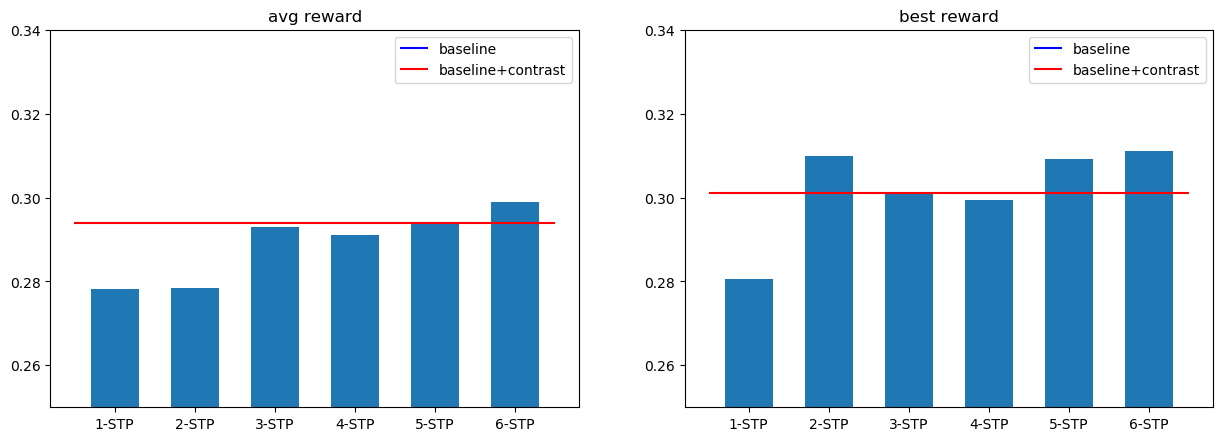

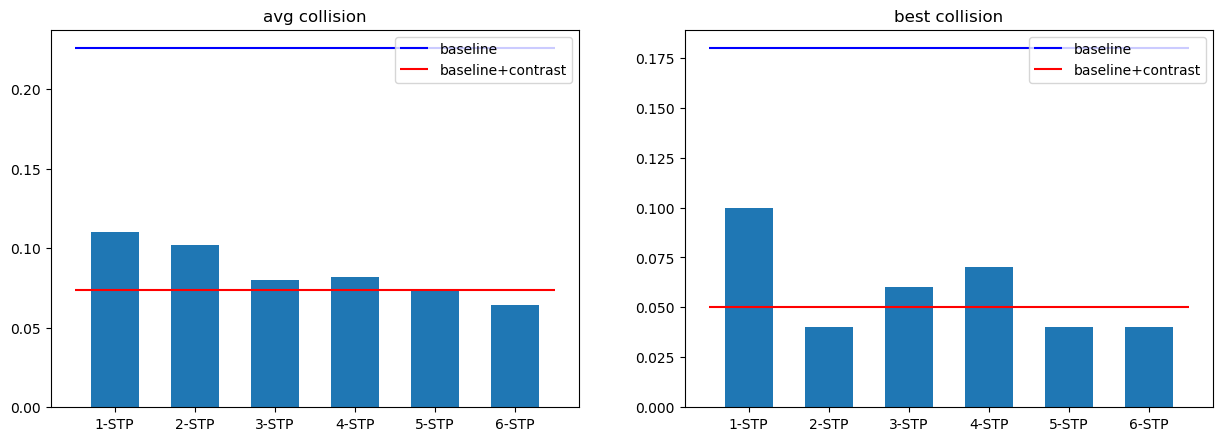

In [27]:
metrics = ['reward', 'collision']
for met in metrics :
    # baseline avg
    avg_base = np.mean([res[met] for res in results_base])
    avg_cont = np.mean([res[met] for res in results_cont])
    
    if met == 'reward' :
        max_base = max([res[met] for res in results_base])
        max_cont = max([res[met] for res in results_cont])
    else :
        max_base = min([res[met] for res in results_base])
        max_cont = min([res[met] for res in results_cont])
    
    x = range(6)
    x_names = ['{}-STP'.format(i+1) for i in x]
    avgs = []
    maxs = []
    for n in x :
        avg = np.mean([res[met] for res in results[n]])
        avgs.append(avg)
        if met=='reward' :
            mx = max([res[met] for res in results[n]])
        else :
            mx = min([res[met] for res in results[n]])
        maxs.append(mx)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    ax1.hlines(avg_base,  xmin=-0.5, xmax=5.5, label='baseline', colors='b')
    ax1.hlines(avg_cont, xmin=-0.5, xmax=5.5, label='baseline+contrast', colors='r')
    
    ax2.hlines(max_base,  xmin=-0.5, xmax=5.5, label='baseline', colors='b')
    ax2.hlines(max_cont, xmin=-0.5, xmax=5.5, label='baseline+contrast', colors='r')
    
    ax1.bar(x, avgs, width=0.6)
    ax2.bar(x, maxs, width=0.6)
    plt.sca(ax1)
    plt.xticks(x, x_names)
    plt.sca(ax2)
    plt.xticks(x, x_names)
    if met == 'reward' :
        ax1.set_ylim(0.25, 0.34)
        ax2.set_ylim(0.25, 0.34)
    ax1.set_title('avg {}'.format(met))
    ax2.set_title('best {}'.format(met))
    ax1.legend()
    ax2.legend()
    plt.show()

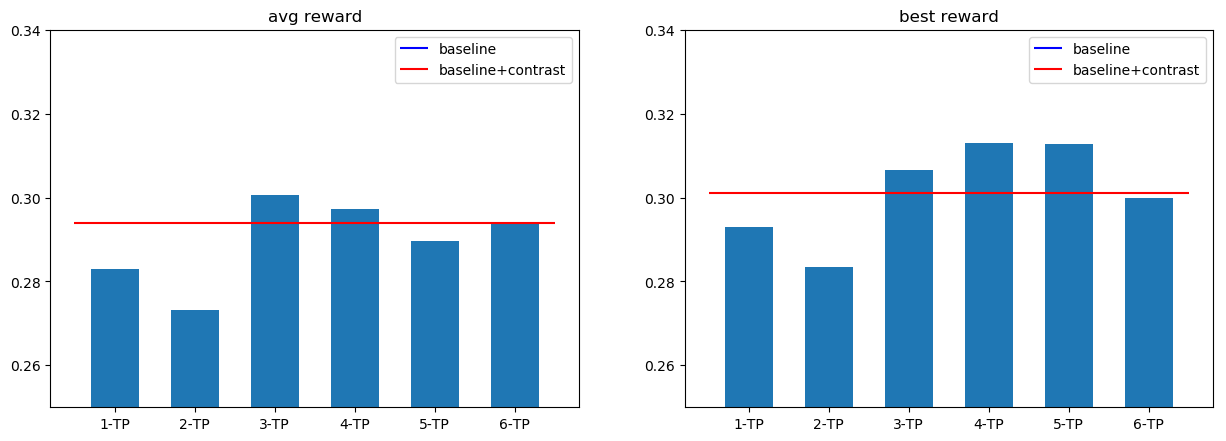

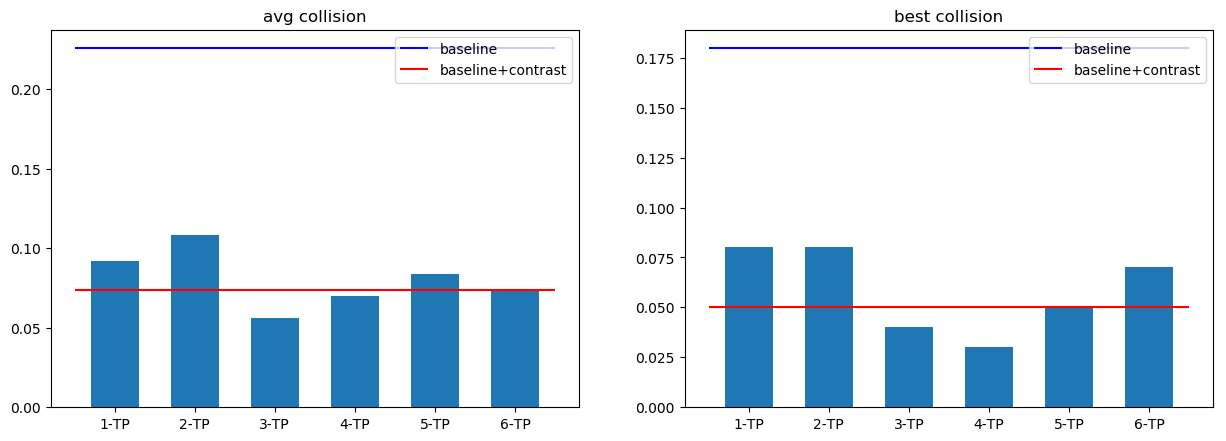

In [28]:
metrics = ['reward', 'collision']
for met in metrics :
    # baseline avg
    avg_base = np.mean([res[met] for res in results_base])
    avg_cont = np.mean([res[met] for res in results_cont])
    
    if met == 'reward' :
        max_base = max([res[met] for res in results_base])
        max_cont = max([res[met] for res in results_cont])
    else :
        max_base = min([res[met] for res in results_base])
        max_cont = min([res[met] for res in results_cont])
    
    x = range(6)
    x_names = ['{}-TP'.format(i+1) for i in x]
    avgs = []
    maxs = []
    for n in x :
        avg = np.mean([res[met] for res in results_traj[n]])
        avgs.append(avg)
        if met=='reward' :
            mx = max([res[met] for res in results_traj[n]])
        else :
            mx = min([res[met] for res in results_traj[n]])
        maxs.append(mx)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    ax1.hlines(avg_base,  xmin=-0.5, xmax=5.5, label='baseline', colors='b')
    ax1.hlines(avg_cont, xmin=-0.5, xmax=5.5, label='baseline+contrast', colors='r')
    
    ax2.hlines(max_base,  xmin=-0.5, xmax=5.5, label='baseline', colors='b')
    ax2.hlines(max_cont, xmin=-0.5, xmax=5.5, label='baseline+contrast', colors='r')
    
    ax1.bar(x, avgs, width=0.6)
    ax2.bar(x, maxs, width=0.6)
    plt.sca(ax1)
    plt.xticks(x, x_names)
    plt.sca(ax2)
    plt.xticks(x, x_names)
    if met == 'reward' :
        ax1.set_ylim(0.25, 0.34)
        ax2.set_ylim(0.25, 0.34)
    ax1.set_title('avg {}'.format(met))
    ax2.set_title('best {}'.format(met))
    ax1.legend()
    ax2.legend()
    plt.show()